In [38]:
import pandas as pd
df_amazon = pd.read_csv('amazon_cells_labelled.csv', names = ['review', 'sentiment']) #read the reviews from file
df_yelp = pd.read_csv('yelp_labelled.csv', names = ['review', 'sentiment']) #read the reviews from file
df_imdb = pd.read_csv('imdb_labelled.csv', names = ['review', 'sentiment']) #read the reviews from file
df_total = pd.concat([df_amazon, df_yelp, df_imdb], ignore_index = True) #concatenate the three dataframes into one
df_total.tail(n=10) #make sure we have all 3000 reviews

,review,sentiment
2990,"The opening sequence of this gem is a classic,...",1
2991,Fans of the genre will be in heaven.,1
2992,Lange had become a great actress.,1
2993,It looked like a wonderful story.,1
2994,I never walked out of a movie faster.,0
2995,I just got bored watching Jessice Lange take h...,0
2996,"Unfortunately, any virtue in this film's produ...",0
2997,"In a word, it is embarrassing.",0
2998,Exceptionally bad!,0
2999,All in all its an insult to one's intelligence...,0


In [39]:
import re #regular expressions package
from nltk.stem.snowball import SnowballStemmer #Snowball Stemmer from NLTK library

snowball_stemmer = SnowballStemmer('english', ignore_stopwords = True) #use English snowball stemmer and ignore stop words
review_data = []

for i in xrange(0,len(df_total['review'])):
    review_text = re.sub("[^a-zA-Z]"," ", df_total['review'][i]) #substitute non alphabet characters with spaces
    words = review_text.lower().split() #convert upper cases into lower cases, and split individual words and make them into a list
    stemmed_words = [snowball_stemmer.stem(word) for word in words] #apply English snowball stemming on each word
    review_data.append(' '.join(stemmed_words)) #join the stemmed words back into sentences, and make a list of reviews
    
print('Original review: {}'.format(df_total['review'][154]))
print('Review after preprocessing: {}'.format(review_data[154]))

Original review: I've bought $5 wired headphones that sound better than these.
Review after preprocessing: i ve bought wire headphon that sound better than these


Shape of the TF-IDF transformed data is: (3000, 2570)
Number of nonzero elements in the TF-IDF matrix is: 17327
This represents only 0.224734111543% of entries in matrix
Among the non zero entries, Min: 0.105609921309, Max: 1.0, Mean: 0.386622708681, Std: 0.15022154459
An example review in transformed space: 
  (0, 2065)	0.303743518298
  (0, 234)	0.360915754887
  (0, 2410)	0.296365014582
  (0, 1027)	0.427419380975
  (0, 193)	0.306028099206
  (0, 2506)	0.447787461729
  (0, 2066)	0.461295280141
In this example, only 7 features out of 2570 have nonzero values 


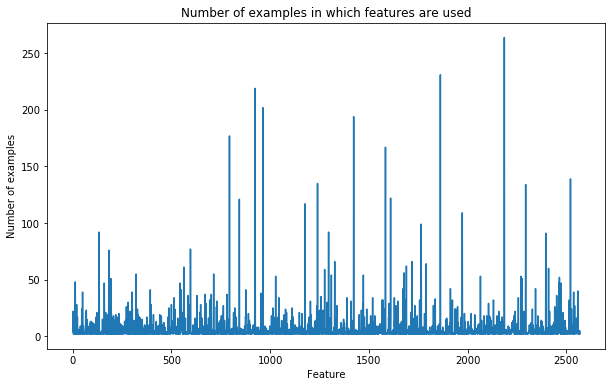

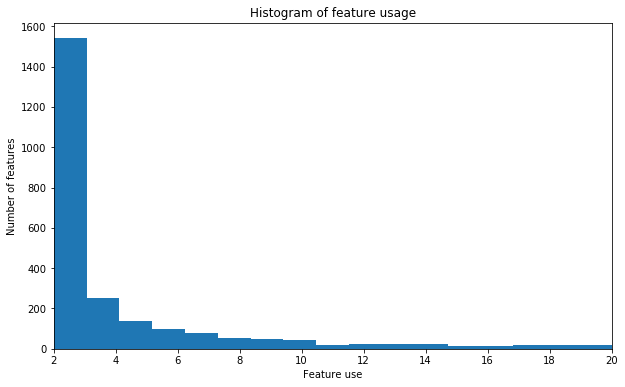

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
import numpy as np
import matplotlib.pyplot as plt

tfv = TFIV(strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1, min_df = 2,
        stop_words = 'english') 

review_data_tfidf = tfv.fit_transform(review_data) #apply tf-idf transformation on the preprocessed data
print('Shape of the TF-IDF transformed data is: {}'.format(review_data_tfidf.shape)) #dimension of the transformed data
print('Number of nonzero elements in the TF-IDF matrix is: {}'.format(len(review_data_tfidf.data)))
print('This represents only {}% of entries in matrix'.format((len(review_data_tfidf.data)*100.0)/(review_data_tfidf.shape[0]*review_data_tfidf.shape[1])))
print('Among the non zero entries, Min: {}, Max: {}, Mean: {}, Std: {}'.format(np.amin(review_data_tfidf.data), np.amax(review_data_tfidf.data), np.mean(review_data_tfidf.data), np.std(review_data_tfidf.data)))
print('An example review in transformed space: ') #one example review after transformation
print(review_data_tfidf[154])
print('In this example, only {} features out of {} have nonzero values '.format(len(review_data_tfidf[154].data), review_data_tfidf.shape[1]))
#print(tfv.idf_[155])
#print(len(review_data_tfidf[:,1].data))
feature_use_count = []
for feature in range(review_data_tfidf.shape[1]): #for each feature out of 2574 features
    feature_use_count.append( np.count_nonzero(review_data_tfidf.todense()[:,feature]) ) #count the number of examples it is used i.e. is non zero 
#in other words, for each column (feature), count the number of rows that have nonzero values

fig, ax = plt.subplots(figsize=(10,6)) #size the plot appropriately
plt.plot(feature_use_count)
plt.title("Number of examples in which features are used")
plt.xlabel('Feature')
plt.ylabel('Number of examples')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(2, 20, 18, endpoint=True)
plt.hist(feature_use_count, bins)
ax.set_xlim([2, 20])
plt.title("Histogram of feature usage")
plt.xlabel("Feature use")
plt.ylabel("Number of features")
plt.show()

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review_data_tfidf, df_total['sentiment'], test_size=0.2, random_state=42, stratify = df_total['sentiment'])
#using stratify to keep same proportion of 1s and 0s in training and testing sets


In [140]:
from sklearn.linear_model import LogisticRegression as LR
import time

model_LR = LR(dual = True, random_state = 0) 
start = time.time()                            
model_LR.fit(X_train, y_train) # Fit the model
end = time.time()

print('Accuracy on training data is: {}'.format(model_LR.score(X_train, y_train)))
print('Accuracy on testing data is: {}'.format(model_LR.score(X_test, y_test)))
print('Training time is: {}'.format(end - start))

Accuracy on training data is: 0.928333333333
Accuracy on testing data is: 0.82
Training time is: 0.0629999637604


In [141]:
from sklearn.grid_search import GridSearchCV

grid_values = {'C':[1, 10, 100, 1000]} # Decide which settings you want for the grid search. 

model_LR_refined = GridSearchCV(LR(dual = True, random_state = 0), grid_values, cv = 20)  

model_LR_refined.fit(X_train, y_train)

print('Accuracy for each grid value: {}'.format(model_LR_refined.grid_scores_)) # print the scores for each grid value
print('Best model is: {}'.format(model_LR_refined.best_estimator_))
print('Testing set accuracy of the best model is: {}'.format(model_LR_refined.best_estimator_.score(X_test, y_test)))

Accuracy for each grid value: [mean: 0.81875, std: 0.03183, params: {'C': 1}, mean: 0.81583, std: 0.03322, params: {'C': 10}, mean: 0.79792, std: 0.03280, params: {'C': 100}, mean: 0.79125, std: 0.03410, params: {'C': 1000}]
Best model is: LogisticRegression(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Testing set accuracy of the best model is: 0.82


In [194]:
from sklearn.naive_bayes import MultinomialNB as MNB


model_NB = MNB() #declare the model
start = time.time()
model_NB.fit(X_train, y_train) #fit the model to the training data
end = time.time()
print('Training time is: {}'.format(end - start))
print('Accuracy on training data is: {}'.format(model_NB.score(X_train, y_train)))
print('Accuracy on testing data is: {}'.format(model_NB.score(X_test, y_test)))

Training time is: 0.00300002098083
Accuracy on training data is: 0.925416666667
Accuracy on testing data is: 0.825


In [195]:
from sklearn.ensemble import RandomForestClassifier as RFC

model_RFC = RFC(random_state = 0) #declare the model with a random state
start = time.time()
model_RFC.fit(X_train, y_train) #fit the model to the training data
end = time.time()

print('Training time is: {}'.format(end - start))
print('Accuracy on training data is: {}'.format(model_RFC.score(X_train, y_train)))
print('Accuracy on testing data is: {}'.format(model_RFC.score(X_test, y_test)))

Training time is: 0.963999986649
Accuracy on training data is: 0.987916666667
Accuracy on testing data is: 0.798333333333


In [196]:
grid_values = {'n_estimators':[10, 100, 200]} #search over three values of n_estimators
model_RFC_refined = GridSearchCV(RFC(random_state = 0), grid_values, cv = 20)
model_RFC_refined.fit(X_train, y_train)
model_RFC_refined.grid_scores_

[mean: 0.76167, std: 0.03178, params: {'n_estimators': 10},
 mean: 0.79292, std: 0.02639, params: {'n_estimators': 100},
 mean: 0.79333, std: 0.02746, params: {'n_estimators': 200}]

In [212]:
print('Best model is: {}'.format(model_RFC_refined.best_estimator_))
print('Testing set accuracy of the best model is: {}'.format(model_RFC_refined.best_estimator_.score(X_test, y_test)))
#model_RFC_refined.best_estimator_.score(X_test, y_test)

Best model is: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Testing set accuracy of the best model is: 0.803333333333


In [211]:
from sklearn.svm import SVC

model_SVM = SVC(random_state = 0) #declare the model with a random state
start = time.time()
model_SVM.fit(X_train, y_train) #fit the model to the training data
end = time.time()
print('Training time is: {}'.format(end - start))
print('Accuracy on training data is: {}'.format(model_SVM.score(X_train, y_train)))
print('Accuracy on testing data is: {}'.format(model_SVM.score(X_test, y_test)))

Training time is: 0.598999977112
Accuracy on training data is: 0.62625
Accuracy on testing data is: 0.62


In [215]:
from sklearn.svm import SVC
grid_values = {'gamma':[.01, .1, 1, 10]} #search over these gamma values  
model_SVM_refined = GridSearchCV(SVC(random_state = 0), grid_values, cv = 20)
model_SVM_refined.fit(X_train, y_train)
model_SVM_refined.grid_scores_

[mean: 0.61583, std: 0.04772, params: {'gamma': 0.01},
 mean: 0.80708, std: 0.03821, params: {'gamma': 0.1},
 mean: 0.81917, std: 0.04041, params: {'gamma': 1},
 mean: 0.56500, std: 0.03714, params: {'gamma': 10}]

In [216]:
print('Testing set accuracy of the best model is: {}'.format(model_SVM_refined.best_estimator_.score(X_test, y_test)))

Testing set accuracy of the best model is: 0.818333333333


In [219]:
#copied over from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[249  51]
 [ 54 246]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.18  0.82]]


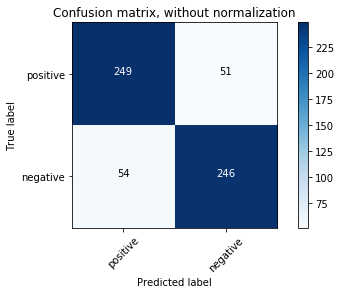

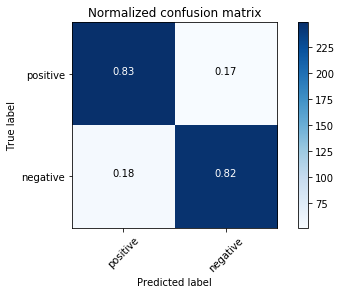

In [221]:
from sklearn.metrics import confusion_matrix
y_pred = model_NB.predict(X_test)
class_names = ['positive', 'negative']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()